## Synchrotron radiation
2D simulations of Single Particle motion with radiative energy loss
***

#### About the simulation

We will be using the 2D version of **ZPIC**. With this particle in cell code we are required to initialize a full plasma instead of a single particle. However, we may still track single particles and eliminate collective effects by decreasing the plasma density.



#### About the phenomenon

In a constant magnetic field $B$, the trajectory of an electron is a circular motion.

The frequency of the motion is $\omega_B=eB/m_e$, with e the electron charge, and $m_e$ the electron mass.

When the field amplitude $B$ is large enough, the electron emits synchrotron radiation.

As the electron radiates its energy, its takes the form of a spiral.

#### The simulation

In [1]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

# get ZPIC 2D
import em2d_rr as zpic
import numpy as np

# Time step
dt = 0.01

# Simulation time
tmax = 22.8

# Number of cells
nx  = [300,300]

# Simulation box size
box = [6,6]


## Plasma slabs
# Particles per cell
ppc = [4,4]

def custom_n0(x):
    if (x>2.9 and x<3.1):
        return 1.0
    else:
        return 0.0

# Use a custom density profile
dens = zpic.Density( type = "custom", custom_x = custom_n0,custom_y = custom_n0  )
# Set up a super low density
dens.n=1e-6
# give it a small velocity to kick of the motion
ufl=100.
#create the species
electrons = zpic.Species( "electrons", m_q=-1,ppc= ppc,
                           density = dens,ufl=[ufl,0,0])

## Positive charge
dens2=zpic.Density( type = "custom", custom_x = custom_n0,custom_y = custom_n0  )
dens2.n=1e-6
positives = zpic.Species( "positrons", m_q=1, ppc=ppc,
                           density = dens2,ufl=[ufl,0,0])


# Initialize simulation
sim = zpic.Simulation( nx, box, dt, species = (electrons,positives) )

#Set the sorting period to 0 in order to track the particle's trajectories 
#(this must be done after initilializng the simulation object)
positives.n_sort=0
electrons.n_sort=0

#Setup the external fields (Remenber that they must be perpendicular)
B=[0,0,100]
E=[0,0,0]


ext = zpic.ExternalField(B_type = 'uniform', B_0 = B,E_type = 'uniform', E_0 = E)

sim.emf.set_ext_fld( ext )



#arays to store the particles trajectories
pos_part_rep =[]
ele_part_rep =[]


while sim.t < 16*2.*np.pi:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    #store the electron trajectories
    ele_part_rep.append(electrons.particles[40].copy())
    #store the positron(ish) trajectories
    pos_part_rep.append(positives.particles[40].copy())

    sim.iter()

In [2]:
#convert trajectories to position arrays
e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in ele_part_rep]
e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in ele_part_rep]

p_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in pos_part_rep]
p_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in pos_part_rep]

# extract the energy of particles from the trajectories
e_gamma_t = [np.sqrt(1.0+i['ux']**2+i['uy']**2+i['uz']**2) for i in ele_part_rep]
p_gamma_t = [np.sqrt(1.0+i['ux']**2+i['uy']**2+i['uz']**2) for i in pos_part_rep]

#create time array
t=np.linspace(0,sim.t,sim.n)

In [3]:
e_vx_t=[(i['ux']) for i in ele_part_rep]
e_vy_t=[(i['uy']) for i in ele_part_rep]


p_vx_t=[(i['ux']) for i in pos_part_rep]
p_vy_t=[(i['uy']) for i in pos_part_rep]

Gyroperiod of electrons

In [4]:
TB = 2. * np.pi * ufl / B[2]

Analytical solution

In [5]:
def solution(gamma0, B, t):
    ini = (gamma0 - 1.) / (gamma0 + 1.)
    k_damp = 1.1237684e-8
    tmp = -2. * k_damp * B**2 * t
    return (1. + ini * np.exp(-2. * k_damp * B**2 * t)) / (1. - ini * np.exp(-2. * k_damp * B**2 * t))

Run the next cell to plot the trajectory of the electron under the influence of these fields

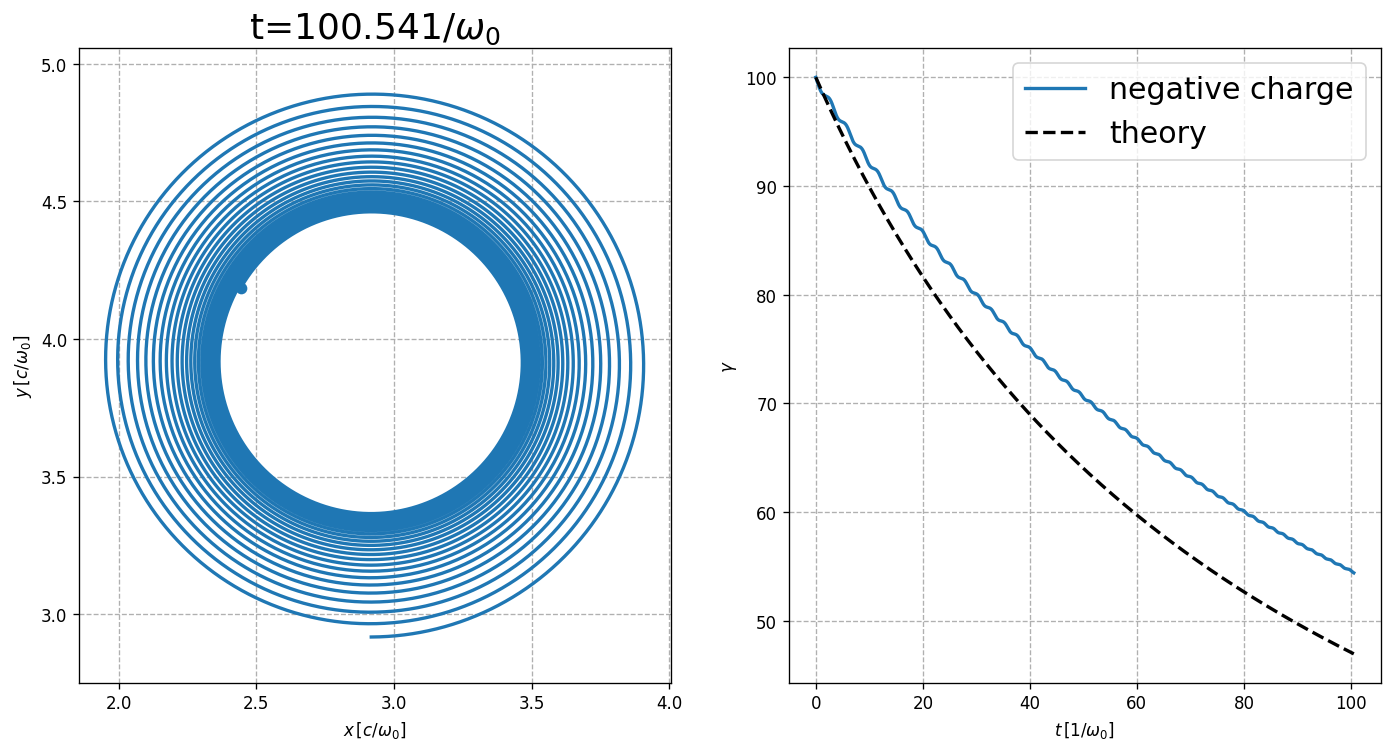

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

#Set up the plot
fig, ax=plt.subplots(1, 2, figsize=(14, 7), dpi=120)
plt.rcParams.update({'font.size': 18})

#left part: xy trajectories

## negative charge trajectory
ax[0].plot(e_posx_t,e_posy_t,lw=2)
ax[0].scatter(e_posx_t[-1],e_posy_t[-1])

#right part: evolution of energy
ax[1].plot(t,e_gamma_t,lw=2,label="negative charge")
ax[1].plot(t,solution(np.sqrt(1.+ufl**2), B[2], t),lw=2,label="theory", c='k', ls='--')

##setup labels, grids, and others
ax[0].grid(True,ls="--")
ax[0].set_xlabel("$x\,[c/\omega_0]$")
ax[0].set_ylabel("$y\,[c/\omega_0]$")
ax[0].set_aspect('equal', 'datalim')
ax[0].set_title("t={:.2f}$1/\omega_0$".format(sim.t))

ax[1].grid(True,ls="--")
ax[1].set_xlabel("$t\,[1/\omega_0]$")
ax[1].set_ylabel("$\gamma$")
ax[1].legend()

plt.show()

**Q:** In which direction does the particle drift? How does it compare to the fields directions?

***
*anwser*
___

Run the next cell to plot the trajectory of the electron under the influence of these fields together with the positive charge

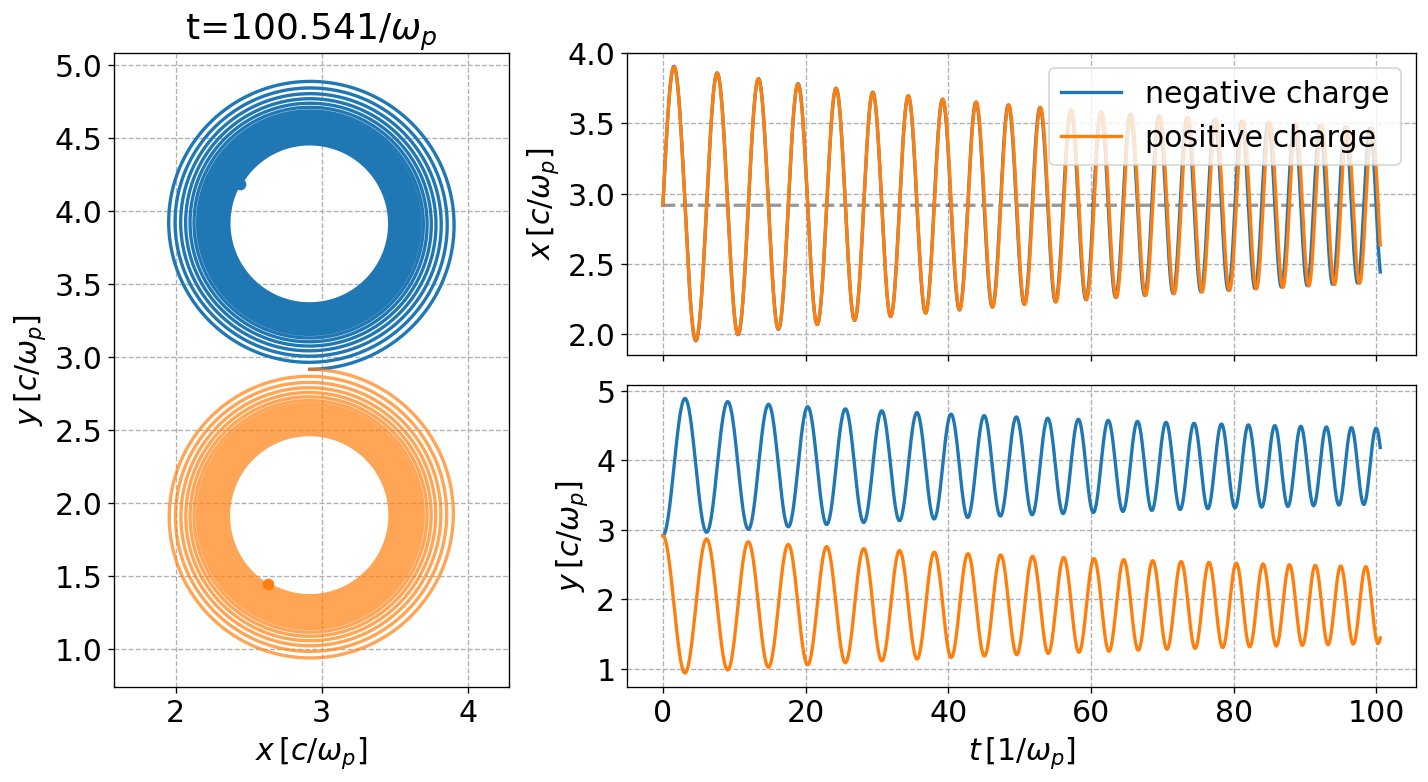

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

#Set up the plot
fig=plt.figure(figsize=(14, 7), dpi=120)
plt.rcParams.update({'font.size': 18})
gs2 = gridspec.GridSpec(2, 2, hspace=0.1,width_ratios=[1, 2])

#left part: xy trajectories
ax = plt.subplot(gs2[:, 0])
## negative charge trajectory
ax.plot(e_posx_t,e_posy_t,lw=2)
ax.scatter(e_posx_t[-1],e_posy_t[-1])
## positive charge trajectory
ax.plot(p_posx_t,p_posy_t,lw=2,alpha=0.7)
ax.scatter(p_posx_t[-1],p_posy_t[-1])

#top right: xt trajectories
ax2 = plt.subplot(gs2[0,1])
ax2.plot(t,E[1]/B[2]*t+(p_posx_t[0]+e_posx_t[0])/2,lw=2,c='k',ls='--',alpha=0.4)
ax2.plot(t,e_posx_t,lw=2,label="negative charge")
ax2.plot(t,p_posx_t,lw=2,label="positive charge")

#bottom right: yt trajectories
ax3 = plt.subplot(gs2[1,1])
ax3.plot(t,e_posy_t,lw=2)
ax3.plot(t,p_posy_t,lw=2)

##setup labels, grids, and others
ax.grid(True,ls="--")
ax.set_xlabel("$x\,[c/\omega_p]$")
ax.set_ylabel("$y\,[c/\omega_p]$")
ax.set_aspect('equal', 'datalim')
ax.set_title("t={:.2f}$1/\omega_p$".format(sim.t))

ax2.set_xticklabels([])
ax2.grid(True,ls="--")
ax2.set_ylabel("$x\,[c/\omega_p]$")
ax2.legend()

ax3.set_ylabel("$y\,[c/\omega_p]$")
ax3.set_xlabel("$t\,[1/\omega_p]$")
ax3.grid(True,ls="--")
plt.show()

##### Questions

* Comment on the direction of the drift of both particles

___
___

* Comment on the amplitude and frequency of both trajectories. *Hint: take a look at the simulation parameters*

___
___

***
***